In [1]:
import pandas as pd
import re
from collections import defaultdict

class ApprOXimate:
    def __init__(self, csv_file_path, verbose=False):
        self.verbose = verbose
        self.load_chemical_data(csv_file_path)
    
    def log(self, message):
        """Print message if verbose mode is enabled"""
        if self.verbose:
            print(f"[DEBUG] {message}")
    
    def load_chemical_data(self, csv_file_path):
        self.log(f"Loading chemical data from {csv_file_path}")
        df = pd.read_csv(csv_file_path)
        self.list1 = defaultdict(list)
        self.list2 = {}
        
        for _, row in df.iterrows():
            element = row['Element']
            ox = int(row['Ox'])
            red = int(row['Red'])
            srp = float(row['SRP (V)'])
            self.list1[element].append((ox, red, srp))
        
        # Sort each element's states by red value (ascending)
        for element in self.list1:
            self.list1[element].sort(key=lambda x: x[1])  # Sort by red value
        
        self.log(f"Loaded {len(self.list1)} elements with variable oxidation states")
        
        # Fixed oxidation states for common elements
        fixed_oxidation_states = {
            'O': -2, 'Na': 1, 'Mg': 2, 'Al': 3, 'Si': 4, 'P': 5, 'S': 6,
        }
        
        for element, ox in fixed_oxidation_states.items():
            self.list2[element] = ox
        
        # Remove fixed elements from variable list
        for element in fixed_oxidation_states:
            if element in self.list1:
                del self.list1[element]
                self.log(f"Removed {element} from variable list (now fixed)")
        
        self.log(f"Fixed oxidation states: {self.list2}")
        self.log(f"Variable elements after cleanup: {list(self.list1.keys())}")
    
    def parse_formula(self, formula_input):
        self.log(f"Parsing formula: {formula_input}")
        pattern = r'([A-Z][a-z]*)(\d*\.?\d*/?\d*\.?\d*)'
        matches = re.findall(pattern, formula_input)
        formula = {}
        
        self.log(f"Regex matches: {matches}")
        
        for element, quantity_str in matches:
            if element not in self.list1 and element not in self.list2:
                print(f'Warning: Element {element} not found in database')
                return None
            
            quantity = 1.0
            if quantity_str:
                if '/' in quantity_str:
                    numerator, denominator = quantity_str.split('/')
                    quantity = float(numerator) / float(denominator)
                    self.log(f"Fractional quantity for {element}: {numerator}/{denominator} = {quantity}")
                else:
                    quantity = float(quantity_str)
                    self.log(f"Quantity for {element}: {quantity}")
            else:
                self.log(f"No quantity specified for {element}, using 1.0")
            
            formula[element] = formula.get(element, 0) + quantity
        
        self.log(f"Parsed formula: {formula}")
        return formula

    def initialize_element_states(self, formula):
        """Initialize each element to its lowest red value state (where red > 0)"""
        element_states = {}
        
        for element in formula:
            if element in self.list1:
                # Find the first state where red > 0
                initial_state = None
                initial_index = 0
                
                for i, state in enumerate(self.list1[element]):
                    if state[1] > 0:  # red > 0
                        initial_state = state
                        initial_index = i
                        break
                
                if initial_state is None:
                    # If no state has red > 0, use the first state as fallback
                    initial_state = self.list1[element][0]
                    initial_index = 0
                
                element_states[element] = {
                    'current_index': initial_index,
                    'current_state': initial_state,
                    'all_states': self.list1[element]
                }
                self.log(f"Initialized {element} to state: ox={initial_state[0]}, red={initial_state[1]}, srp={initial_state[2]}")
        
        return element_states

    def calculate_current_charge(self, formula, element_states):
        """Calculate the current total charge based on current oxidation states"""
        sum_non_m = 0
        sum_m = 0
        
        self.log("Calculating charges:")
        for element, quantity in formula.items():
            if element in self.list2:
                red = self.list2[element]
                charge_contribution = quantity * red
                sum_non_m += charge_contribution
                self.log(f"  {element} (fixed): {quantity} × {red} = {charge_contribution}")
            else:
                current_state = element_states[element]['current_state']
                charge_contribution = quantity * current_state[1]  # Use red value
                sum_m += charge_contribution
                self.log(f"  {element} (variable): {quantity} × {current_state[1]} = {charge_contribution} (ox={current_state[0]}, red={current_state[1]}, srp={current_state[2]})")
        
        total_charge = round(sum_non_m + sum_m, 5)
        self.log(f"Total charge: {sum_non_m} + {sum_m} = {total_charge}")
        return total_charge

    def find_lowest_srp_element(self, formula, element_states):
        """Find the element with the lowest SRP among variable elements (excluding fixed elements)"""
        lowest_srp_element = None
        lowest_srp = float('inf')
        
        self.log("Finding element with lowest SRP:")
        for element, quantity in formula.items():
            # Only consider variable elements (not fixed elements in self.list2)
            if element in element_states and element not in self.list2:
                current_state = element_states[element]['current_state']
                self.log(f"  {element}: SRP = {current_state[2]}")
                if current_state[2] < lowest_srp:
                    lowest_srp = current_state[2]
                    lowest_srp_element = {
                        'element': element,
                        'quantity': quantity,
                        'state': current_state
                    }
        
        if lowest_srp_element:
            self.log(f"Element with lowest SRP: {lowest_srp_element['element']} (SRP = {lowest_srp})")
        else:
            self.log("No element with lowest SRP found")
        
        return lowest_srp_element

    def calculate_charge_with_delta(self, lowest_srp_element, total_charge):
        """Calculate what the charge would be if we fully oxidize the lowest SRP element"""
        if not lowest_srp_element:
            return 0, 0
        
        current_state = lowest_srp_element['state']
        delta_ox_max = round((current_state[0] - current_state[1]) * lowest_srp_element['quantity'], 5)
        charge_with_delta = round(delta_ox_max + total_charge, 5)
        
        self.log(f"Delta oxidation max: ({current_state[0]} - {current_state[1]}) × {lowest_srp_element['quantity']} = {delta_ox_max}")
        self.log(f"Charge with delta: {delta_ox_max} + {total_charge} = {charge_with_delta}")
        
        return delta_ox_max, charge_with_delta

    def update_oxidation_state(self, lowest_srp_element, element_states):
        """Update the oxidation state of an element to the next available state in stepwise manner"""
        element = lowest_srp_element['element']
        current_index = element_states[element]['current_index']
        all_states = element_states[element]['all_states']
        
        # Move to the next state in the stepwise progression
        if current_index < len(all_states) - 1:
            next_index = current_index + 1
            next_state = all_states[next_index]
            
            element_states[element]['current_index'] = next_index
            element_states[element]['current_state'] = next_state
            
            self.log(f"Updated {element} from index {current_index} to {next_index}")
            self.log(f"New state: ox={next_state[0]}, red={next_state[1]}, srp={next_state[2]}")
        else:
            # If we're at the last state, create a new state where red = ox
            current_state = element_states[element]['current_state']
            new_state = (current_state[0], current_state[0], float('inf'))
            
            # Add the new state to the list and update
            element_states[element]['all_states'].append(new_state)
            element_states[element]['current_index'] = len(element_states[element]['all_states']) - 1
            element_states[element]['current_state'] = new_state
            
            self.log(f"Created new final state for {element}: ox={new_state[0]}, red={new_state[1]}, srp={new_state[2]}")
            
    def charge_balance(self, formula):
        """Main charge balancing function"""
        self.log("=== Starting charge balance calculation ===")
        self.log(f"Input formula: {formula}")
        
        # Initialize element states
        element_states = self.initialize_element_states(formula)
        
        # Perform iterative charge balancing
        balance_result = self.perform_charge_balance_iterations(formula, element_states)
        
        # Calculate final charge
        final_charge = self.calculate_final_charge(formula, element_states, balance_result)
        
        # Build and return result string
        result = self.build_result_string(formula, element_states, balance_result, final_charge)
        
        return result

    def calculate_final_charge(self, formula, element_states, balance_result):
        """Calculate the final charge after balancing"""
        self.log("\n=== Calculating final charge ===")
        
        element_with_final_lowest_srp = balance_result['element_with_final_lowest_srp']
        final_delta_ox_max = balance_result['final_delta_ox_max']
        final_charge_with_delta = balance_result['final_charge_with_delta']
        element_quantity = balance_result['element_quantity']
        final_ox = balance_result['final_ox']
        final_red = balance_result['final_red']
        
        final_charge = 0
        
        # Calculate charge from fixed and other variable elements
        for element, quantity in formula.items():
            if element in self.list2:
                charge_contribution = quantity * self.list2[element]
                final_charge += charge_contribution
                self.log(f"Final charge from {element}: {quantity} × {self.list2[element]} = {charge_contribution}")
            elif element != element_with_final_lowest_srp:
                current_state = element_states[element]['current_state']
                charge_contribution = quantity * current_state[1]  # Use red value
                final_charge += charge_contribution
                self.log(f"Final charge from {element}: {quantity} × {current_state[1]} = {charge_contribution}")
        
        # Handle the element with final lowest SRP
        if element_with_final_lowest_srp and (final_charge_with_delta == 0 or final_charge_with_delta > 0):
            if final_delta_ox_max != 0:  # Only adjust if there's actually a difference in oxidation states
                adjusted_quant = round(element_quantity * (final_charge_with_delta / final_delta_ox_max), 5)
                remaining_quant = round(element_quantity - adjusted_quant, 5)
                
                self.log(f"Adjusting {element_with_final_lowest_srp}:")
                self.log(f"  Adjusted quantity: {element_quantity} × ({final_charge_with_delta} / {final_delta_ox_max}) = {adjusted_quant}")
                self.log(f"  Remaining quantity: {element_quantity} - {adjusted_quant} = {remaining_quant}")
                
                if adjusted_quant > 0:
                    charge_contribution = adjusted_quant * final_red
                    final_charge += charge_contribution
                    self.log(f"  Charge from adjusted: {adjusted_quant} × {final_red} = {charge_contribution}")
                if remaining_quant > 0:
                    charge_contribution = remaining_quant * final_ox
                    final_charge += charge_contribution
                    self.log(f"  Charge from remaining: {remaining_quant} × {final_ox} = {charge_contribution}")
            else:
                # If no difference in oxidation states, just use the original quantity
                charge_contribution = element_quantity * final_red
                final_charge += charge_contribution
                self.log(f"No oxidation state difference for {element_with_final_lowest_srp}: {element_quantity} × {final_red} = {charge_contribution}")
        
        final_charge = round(final_charge, 5)
        self.log(f"Final total charge: {final_charge}")
        
        return final_charge

    def perform_charge_balance_iterations(self, formula, element_states):
        """Perform the iterative charge balancing algorithm"""
        self.log("=== Starting charge balance iterations ===")
        
        total_charge = 0
        previous_charge_with_delta = float('nan')
        element_with_final_lowest_srp = None
        final_delta_ox_max = 0
        final_charge_with_delta = 0
        element_quantity = 0
        final_ox = 0
        final_red = 0
        
        iteration_count = 0
        max_iterations = 100
        
        while True:
            iteration_count += 1
            self.log(f"\n--- Iteration {iteration_count} ---")
            
            if iteration_count > max_iterations:
                self.log("Maximum iterations reached, breaking")
                break
            
            # Calculate current charge
            total_charge = self.calculate_current_charge(formula, element_states)
            
            # Find element with lowest SRP
            lowest_srp_element = self.find_lowest_srp_element(formula, element_states)
            
            if not lowest_srp_element:
                self.log("No element with lowest SRP found, breaking")
                break
            
            # Calculate charge with delta
            delta_ox_max, charge_with_delta = self.calculate_charge_with_delta(lowest_srp_element, total_charge)
            
            if charge_with_delta == previous_charge_with_delta:
                self.log("Charge with delta equals previous, breaking")
                break
            
            previous_charge_with_delta = charge_with_delta
            
            if charge_with_delta < 0:
                self.update_oxidation_state(lowest_srp_element, element_states)
                total_charge += delta_ox_max
            else:
                self.log("Charge with delta >= 0, finalizing")
                element_with_final_lowest_srp = lowest_srp_element['element']
                final_delta_ox_max = delta_ox_max
                final_charge_with_delta = charge_with_delta
                element_quantity = lowest_srp_element['quantity']
                final_ox = lowest_srp_element['state'][0]
                final_red = lowest_srp_element['state'][1]
                self.log(f"Final element: {element_with_final_lowest_srp}")
                self.log(f"Final delta ox max: {final_delta_ox_max}")
                self.log(f"Final charge with delta: {final_charge_with_delta}")
                break
        
        return {
            'element_with_final_lowest_srp': element_with_final_lowest_srp,
            'final_delta_ox_max': final_delta_ox_max,
            'final_charge_with_delta': final_charge_with_delta,
            'element_quantity': element_quantity,
            'final_ox': final_ox,
            'final_red': final_red
        }
    
    def build_result_string(self, formula, element_states, balance_result, final_charge):
        """Build the final result string"""
        self.log("\n=== Building result string ===")
        
        element_with_final_lowest_srp = balance_result['element_with_final_lowest_srp']
        final_delta_ox_max = balance_result['final_delta_ox_max']
        final_charge_with_delta = balance_result['final_charge_with_delta']
        element_quantity = balance_result['element_quantity']
        final_ox = balance_result['final_ox']
        final_red = balance_result['final_red']
        
        result_parts = []
        
        # Add fixed elements first
        for element in sorted(formula.keys()):
            if element in self.list2:
                part = f"{element}:{self.list2[element]}:{formula[element]}"
                result_parts.append(part)
                self.log(f"Added fixed element: {part}")
        
        # Add variable elements
        for element in sorted(formula.keys()):
            if element in element_states and element != element_with_final_lowest_srp:
                current_state = element_states[element]['current_state']
                part = f"{element}:{current_state[1]}:{formula[element]}"
                result_parts.append(part)
                self.log(f"Added variable element: {part}")
        
        # Handle element with lowest SRP
        if element_with_final_lowest_srp and (final_charge_with_delta == 0 or final_charge_with_delta > 0):
            if final_delta_ox_max != 0:
                adjusted_quant = round(element_quantity * (final_charge_with_delta / final_delta_ox_max), 5)
                remaining_quant = round(element_quantity - adjusted_quant, 5)
                
                if adjusted_quant > 0:
                    part = f"{element_with_final_lowest_srp}:{final_red}:{adjusted_quant}"
                    result_parts.append(part)
                    self.log(f"Added adjusted lowest SRP element: {part}")
                if remaining_quant > 0:
                    part = f"{element_with_final_lowest_srp}:{final_ox}:{remaining_quant}"
                    result_parts.append(part)
                    self.log(f"Added remaining lowest SRP element: {part}")
            else:
                # If no difference in oxidation states, just show the original quantity
                part = f"{element_with_final_lowest_srp}:{final_red}:{element_quantity}"
                result_parts.append(part)
                self.log(f"Added lowest SRP element (no difference): {part}")
        
        result_parts.append(f"FinalChargeBalance:{final_charge}")
        self.log(f"Added final charge balance: FinalChargeBalance:{final_charge}")
        
        result = ";".join(result_parts)
        self.log(f"Final result: {result}")
        
        return result

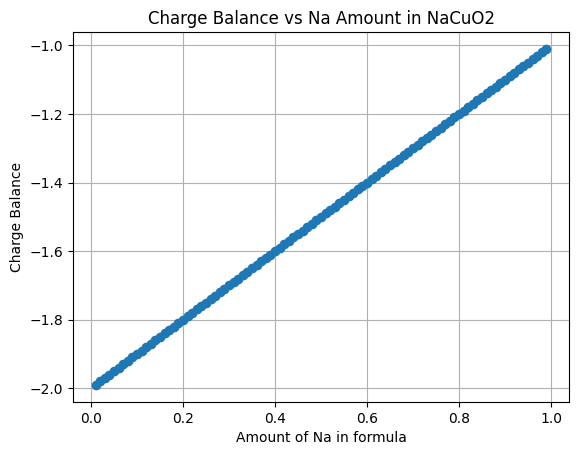

In [11]:
import numpy as np
import matplotlib.pyplot as plt

analyzer = ApprOXimate('all_elements_oxidation_states(in).csv', verbose=False)

formula = "NaCuO2"

parsed_formula = analyzer.parse_formula(formula)


def decreasing_alkali_metal(parsed_formula, alkali_metal, interval=0.01):
    alkali_metal_amount = parsed_formula.get(alkali_metal, 0)
   
    # Generate values to test
    values = np.arange(interval, alkali_metal_amount, interval)
   
    # Compute charge balances efficiently
    charge_balances = [
        float(analyzer.charge_balance({**parsed_formula, alkali_metal: val}).split(';')[-1].split(':')[-1])
        for val in values
    ]
   
    return values, charge_balances
def plot_charge_balance_vs_alkali_metal(formula, alkali_metal, values, charge_balances):
    # Plotting
    plt.plot(values, charge_balances, marker='o')
    plt.xlabel(f'Amount of {alkali_metal} in formula')
    plt.ylabel('Charge Balance')
    plt.title(f'Charge Balance vs {alkali_metal} Amount in {formula}')
    plt.grid()
    plt.show()
   
values, charge_balances = decreasing_alkali_metal(parsed_formula, 'Na', interval=0.01)
plot_charge_balance_vs_alkali_metal(formula, 'Na', values, charge_balances)

In [3]:
import pandas as pd
import numpy as np

import ipywidgets as widgets
from IPython.display import display

import plotly.graph_objects as go

import io

class OxidationStateCalculator:
    """
    A complete oxidation state calculator with interactive user interface.
    This class handles both single formula analysis and batch processing of Excel files.
    """
    
    def __init__(self, analyzer):
        """
        Initialize the calculator with an ApprOXimate analyzer instance
        
        Args:
            analyzer: ApprOXimate analyzer instance for processing chemical formulas
        """
        self.analyzer = analyzer
        
        # Store processed results for user access
        self.processed_df = None
        self.single_result_df = None
        
        # Initialize the user interface
        self._create_widgets()
        self._setup_event_handlers()
        self.interface = self._create_layout()
    
    # ================================
    # CORE PROCESSING METHODS
    # ================================
    
    def process_single_formula(self, input_text):
        """
        Process a single chemical formula and return oxidation state data
        
        Args:
            input_text (str): Chemical formula (e.g., "H2SO4")
        
        Returns:
            tuple: (DataFrame with results, summary message)
        """
        try:
            # Parse the chemical formula using the analyzer
            parsed_formula = self.analyzer.parse_formula(input_text)
            if parsed_formula is None:
                return None, "Error: Unable to parse formula"
            
            # Calculate charge balance and oxidation states
            calculation_result = self.analyzer.charge_balance(parsed_formula)
            result_parts = calculation_result.split(";")
            
            # Prepare data for creating a table (DataFrame)
            element_data = []
            final_charge = None
            
            # Extract information from each part of the result
            for item in result_parts:
                if item.startswith("FinalChargeBalance:"):
                    # Extract the final charge balance value
                    charge_label, charge_value = item.split(":")
                    final_charge = float(charge_value)
                else:
                    # Extract element, oxidation state, and quantity
                    element, oxidation_state, quantity = item.split(":")
                    element_data.append({
                        'Element': element,
                        'Oxidation_State': int(float(oxidation_state)),
                        'Quantity': float(quantity)
                    })
            
            # Create a table (DataFrame) from the extracted data
            results_table = pd.DataFrame(element_data)
            summary_message = f"Final Charge Balance: {final_charge}"
            
            return results_table, summary_message
            
        except Exception as error:
            return None, f"Error processing formula: {str(error)}"
    
    def extract_oxidation_data(self, result_string):
        """
        Parse the analyzer result string and extract oxidation state information
        
        Args:
            result_string (str): Raw result from the analyzer
        
        Returns:
            dict: Dictionary with element oxidation states and quantities
        """
        result_parts = result_string.split(";")
        element_data = {}
        
        for item in result_parts:
            # Skip the final charge balance entry
            if not item.startswith("FinalChargeBalance:"):
                element, oxidation_state, quantity = item.split(":")
                oxidation_state = int(float(oxidation_state))
                quantity = float(quantity)
                
                # Initialize element dictionary if not exists
                if element not in element_data:
                    element_data[element] = {}
                
                # Add or sum quantities for the same oxidation state
                if oxidation_state in element_data[element]:
                    element_data[element][oxidation_state] += quantity
                else:
                    element_data[element][oxidation_state] = quantity
        
        return element_data
    
    def find_all_oxidation_combinations(self, df, composition_column):
        """
        Scan all compositions to find which element-oxidation state combinations exist
        This helps create appropriate columns in the final table
        
        Args:
            df (DataFrame): Input data containing compositions
            composition_column (str): Name of column with chemical formulas
        
        Returns:
            list: Sorted list of element-oxidation state combinations (e.g., ["H+1", "O-2"])
        """
        found_combinations = set()
        
        # Check each composition in the dataset
        for index, row in df.iterrows():
            composition = str(row[composition_column])
            try:
                parsed_formula = self.analyzer.parse_formula(composition)
                if parsed_formula is not None:
                    result = self.analyzer.charge_balance(parsed_formula)
                    element_data = self.extract_oxidation_data(result)
                    
                    # Add each element-oxidation state combination to our set
                    for element, oxidation_states in element_data.items():
                        for oxidation_state in oxidation_states.keys():
                            # Format: element name + oxidation state with sign
                            combination = f"{element}{oxidation_state:+d}"
                            found_combinations.add(combination)
            except:
                # Skip problematic entries and continue
                continue
        
        return sorted(list(found_combinations))
    
    def process_excel_file(self, file_content, composition_column):
        """
        Process an Excel file containing multiple chemical compositions
        
        Args:
            file_content (bytes): Content of the uploaded Excel file
            composition_column (str): Name of column containing chemical formulas
        
        Returns:
            tuple: (Processed DataFrame, status message)
        """
        try:
            # Read the Excel file into a DataFrame (table)
            input_df = pd.read_excel(io.BytesIO(file_content))
            
            # Check if the specified column exists
            if composition_column not in input_df.columns:
                return None, f"Column '{composition_column}' not found in Excel file"
            
            # Find all element-oxidation state combinations in the dataset
            oxidation_combinations = self.find_all_oxidation_combinations(input_df, composition_column)
            
            # Create a copy of the original data to add new columns
            result_df = input_df.copy()
            
            # Add a column for each element-oxidation state combination
            for combination in oxidation_combinations:
                result_df[combination] = np.nan  # Initialize with empty values
            
            # Add column for final charge balance
            result_df['Final_Charge_Balance'] = np.nan
            
            # Process each row (composition) in the dataset
            for index, row in input_df.iterrows():
                composition = str(row[composition_column])
                
                try:
                    # Parse and analyze the composition
                    parsed_formula = self.analyzer.parse_formula(composition)
                    if parsed_formula is not None:
                        result = self.analyzer.charge_balance(parsed_formula)
                        result_parts = result.split(";")
                        
                        # Extract final charge balance
                        final_charge = None
                        for item in result_parts:
                            if item.startswith("FinalChargeBalance:"):
                                charge_label, charge_value = item.split(":")
                                final_charge = float(charge_value)
                                break
                        
                        # Store the final charge balance
                        result_df.at[index, 'Final_Charge_Balance'] = final_charge
                        
                        # Get oxidation state data for this composition
                        element_data = self.extract_oxidation_data(result)
                        
                        # Initialize all relevant columns to 0 for elements in this composition
                        elements_in_composition = set(element_data.keys())
                        for element in elements_in_composition:
                            for combination in oxidation_combinations:
                                if combination.startswith(element):
                                    result_df.at[index, combination] = 0
                        
                        # Fill in the actual calculated values
                        for element, oxidation_states in element_data.items():
                            for oxidation_state, quantity in oxidation_states.items():
                                column_name = f"{element}{oxidation_state:+d}"
                                if column_name in oxidation_combinations:
                                    result_df.at[index, column_name] = quantity
                                    
                except Exception as error:
                    print(f"Error processing composition '{composition}' at row {index}: {str(error)}")
                    continue
            
            return result_df, "Success"
            
        except Exception as error:
            return None, f"Error processing Excel file: {str(error)}"
    
    # ================================
    # USER INTERFACE CREATION METHODS
    # ================================
    
    def _create_widgets(self):
        """Create all the user interface widgets"""
        
        # ----------------
        # Single Formula Section Widgets
        # ----------------
        
        # Text input box for entering chemical formulas
        self.formula_input = widgets.Text(
            value='',
            description='Chemical Formula:',
            placeholder='Enter formula (e.g., H2SO4)',
            disabled=False,
            style={'description_width': '140px'}
        )
        
        # Button to trigger calculation
        self.calculate_button = widgets.Button(
            description='Calculate Oxidation States',
            button_style='info',  # Blue color
            tooltip='Click to analyze the chemical formula',
            icon='check',
            layout=widgets.Layout(width='250px', height='40px')
        )
        
        # Area to display results for single formula
        self.single_results_display = widgets.HTML(value="Enter a chemical formula and click 'Calculate' to see results")
        
        # ----------------
        # Excel Processing Section Widgets
        # ----------------
        
        # File upload widget for Excel files
        self.excel_uploader = widgets.FileUpload(
            accept='.xlsx,.xls',  # Only accept Excel files
            multiple=False,       # Only one file at a time
            description='Upload Excel File',
            button_style='success'  # Green color
        )
        
        # Text input for specifying which column contains the chemical formulas
        self.column_name_input = widgets.Text(
            value='Composition',
            description='Formula Column:',
            placeholder='Name of column with formulas',
            disabled=False,
            style={'description_width': '140px'},
            tooltip='Specify the exact name of the column containing chemical compositions'
        )
        
        # Button to process the Excel file
        self.process_excel_button = widgets.Button(
            description='Process Excel File',
            button_style='info',  # Orange color
            tooltip='Click to analyze all formulas in the Excel file',
            icon='table',
            layout=widgets.Layout(width='250px', height='40px')
        )
        
        # Status display for Excel processing
        self.excel_status_display = widgets.HTML(value="Upload an Excel file to process multiple compositions")
        
        # Area to display Excel processing results
        self.excel_results_display = widgets.HTML(value="")
    
    def _setup_event_handlers(self):
        """Connect button clicks to their handler methods"""
        self.calculate_button.on_click(self.handle_single_formula_calculation)
        self.process_excel_button.on_click(self.handle_excel_processing)
    
    def _create_layout(self):
        """Create and return the complete user interface layout"""
        
        # Section for single formula processing
        single_formula_section = widgets.VBox([
            widgets.HTML("<h3 style='color: #495057; border-bottom: 2px solid #fd7e14; padding-bottom: 5px;'> Single Formula Analysis</h3>"),
            widgets.HTML("<p style='color: #6c757d;'>Enter a chemical formula (like H₂SO₄ or CaCl₂) to calculate the oxidation states of each element.</p>"),
            widgets.HBox([self.formula_input, self.calculate_button], layout=widgets.Layout(align_items='flex-end')),
            self.single_results_display
        ], layout=widgets.Layout(
            border='2px solid #fd7e14', 
            border_radius='10px',
            padding='20px', 
            margin='10px',
            background_color='#f8f9ff'
        ))
        
        # Section for Excel file processing
        excel_processing_section = widgets.VBox([
            widgets.HTML("<h3 style='color: #495057; border-bottom: 2px solid #fd7e14; padding-bottom: 5px;'> Excel File Processing</h3>"),
            widgets.HTML("<p style='color: #6c757d;'>Upload an Excel file containing chemical compositions to analyze multiple formulas at once.</p>"),
            widgets.HBox([self.excel_uploader, self.column_name_input], layout=widgets.Layout(align_items='flex-end')),
            self.process_excel_button,
            self.excel_status_display,
            self.excel_results_display
        ], layout=widgets.Layout(
            border='2px solid #fd7e14', 
            border_radius='10px',
            padding='20px', 
            margin='10px',
            background_color='#f8fff8'
        ))
        
        # Main interface combining both sections
        main_interface = widgets.VBox([
            widgets.HTML("""
            <div style='text-align: center; padding: 20px; background: black; color: white; border-radius: 10px; margin-bottom: 20px;'>
                <h1 style='margin: 0; font-size: 28px; color: white;'> appr<span style="color: orange;">OX</span>imate</h1>
                <p style='margin: 10px 0 0 0; font-size: 16px; opacity: 0.9;'> oxidation state analyser with mixed oxidation state functionality </p>
            </div>
            """),
            single_formula_section,
            excel_processing_section
        ])
        
        return main_interface
    
    # ================================
    # EVENT HANDLER METHODS
    # ================================
    
    def handle_single_formula_calculation(self, button_click):
        """Handle when user clicks the calculate button for single formula"""
        
        user_formula = self.formula_input.value.strip()
        if not user_formula:
            self.single_results_display.value = "Please enter a chemical formula"
            return
        
        # Process the formula
        results_table, summary_info = self.process_single_formula(user_formula)
        
        if results_table is not None:
            # Store results for user access
            self.single_result_df = results_table
            
            # Convert the results table to HTML for display
            html_table = results_table.to_html(
                index=False,  # Don't show row numbers
                escape=False,
                classes='styled-table',
                table_id='single-formula-table'
            )
            
            # Create styled HTML display
            self.single_results_display.value = f'''
            <div style="margin-top: 15px;">
                <h4 style="color: #2c3e50;">Analysis Results</h4>
                <p><strong>Formula Analyzed:</strong> <code style="background-color: #f8f9fa; padding: 2px 6px; border-radius: 3px;">{user_formula}</code></p>
                <p><strong>{summary_info}</strong></p>
                <div style="max-height: 400px; overflow: auto; border: 2px solid #fd7e14; border-radius: 8px; margin: 10px 0;">
                    <style>
                        .styled-table {{
                            width: 100%;
                            border-collapse: collapse;
                            margin: 0;
                            font-family: Arial, sans-serif;
                            font-size: 14px;
                        }}
                        .styled-table th {{
                            background-color: #fd7e14;
                            color: white;
                            padding: 12px 8px;
                            text-align: center;
                            font-weight: bold;
                            position: sticky;
                            top: 0;
                            z-index: 10;
                        }}
                        .styled-table td {{
                            padding: 10px 8px;
                            text-align: center;
                            border-bottom: 1px solid #dee2e6;
                        }}
                        .styled-table tr:nth-child(even) {{
                            background-color: #f8f9fa;
                        }}
                        .styled-table tr:hover {{
                            background-color: #e3f2fd;
                        }}
                    </style>
                    {html_table}
                </div>
                <p style="margin-top: 10px; font-style: italic; color: #6c757d;">
                    💡 The results are also stored in the variable <code>calculator.single_result_df</code> for further analysis.
                </p>
            </div>
            '''
        else:
            self.single_results_display.value = f'<div style="color: #dc3545; font-weight: bold;"> {summary_info}</div>'
            self.single_result_df = None
    
    def handle_excel_processing(self, button_click):
        """Handle when user clicks the process Excel button"""
        
        # Check if a file was uploaded
        if not self.excel_uploader.value:
            self.excel_status_display.value = '<div style="color: #dc3545;"> Please upload an Excel file first</div>'
            return
        
        try:
            # Get the uploaded file content
            # Handle different formats of uploaded file data
            if isinstance(self.excel_uploader.value, tuple):
                uploaded_file = self.excel_uploader.value[0]
            else:
                uploaded_file = list(self.excel_uploader.value.values())[0]
            
            # Extract file content
            if hasattr(uploaded_file, 'content'):
                file_content = uploaded_file.content
            elif isinstance(uploaded_file, dict):
                file_content = uploaded_file['content']
            else:
                file_content = uploaded_file
            
            self.excel_status_display.value = '<div style="color: #fd7e14;"> Processing Excel file...</div>'
            
            # Process the Excel file
            results_table, status_message = self.process_excel_file(file_content, self.column_name_input.value)
            
            if results_table is not None:
                # Store results for user access
                self.processed_df = results_table
                self.excel_status_display.value = f'<div style="color: #fd7e14;"> Success! Processed {len(results_table)} rows.</div>'
                
                # Convert results to HTML table
                html_table = results_table.to_html(
                    index=False,
                    escape=False,
                    classes='styled-table',
                    table_id='excel-results-table'
                )
                
                # Display the results
                self.excel_results_display.value = f'''
                <div style="margin-top: 15px;">
                    <h4 style="color: #2c3e50;">Excel Processing Results</h4>
                    <p><strong>Total Rows Processed:</strong> {len(results_table)}</p>
                    <p><strong>Formula Column:</strong> <code style="background-color: #f8f9fa; padding: 2px 6px; border-radius: 3px;">{self.column_name_input.value}</code></p>
                    <div style="max-height: 500px; overflow: auto; border: 2px solid #fd7e14; border-radius: 8px; margin: 10px 0;">
                        <style>
                            #excel-results-table {{
                                width: 100%;
                                border-collapse: collapse;
                                margin: 0;
                                font-family: Arial, sans-serif;
                                font-size: 12px;
                            }}
                            #excel-results-table th {{
                                background-color: #fd7e14;
                                color: white;
                                padding: 10px 6px;
                                text-align: center;
                                font-weight: bold;
                                position: sticky;
                                top: 0;
                                z-index: 10;
                            }}
                            #excel-results-table td {{
                                padding: 8px 6px;
                                text-align: center;
                                border-bottom: 1px solid #dee2e6;
                            }}
                            #excel-results-table tr:nth-child(even) {{
                                background-color: #f8f9fa;
                            }}
                            #excel-results-table tr:hover {{
                                background-color: #d4edda;
                            }}
                        </style>
                        {html_table}
                    </div>
                    <p style="margin-top: 10px; font-style: italic; color: #6c757d;">
                        💡 The results are also stored in the variable <code>calculator.processed_df</code> for further analysis.
                    </p>
                </div>
                '''
            else:
                self.excel_status_display.value = f'<div style="color: #dc3545;"> Error: {status_message}</div>'
                self.excel_results_display.value = ""
                
        except Exception as error:
            self.excel_status_display.value = f'<div style="color: #dc3545;"> Error: {str(error)}</div>'
            self.excel_results_display.value = ""
    
    def display(self):
        """Display the calculator interface"""
        display(self.interface)
    
    def get_single_results(self):
        """Get the results from single formula processing"""
        return self.single_result_df
    
    def get_excel_results(self):
        """Get the results from Excel file processing"""
        return self.processed_df
    
# Initialize the analyzer (assumes ApprOXimate class is available)
analyzer = ApprOXimate('all_elements_oxidation_states(in).csv')

# Create the calculator instance
calculator = OxidationStateCalculator(analyzer)

# Display the user interface
calculator.display()

# Make the calculator available in the global scope
globals()['calculator'] = calculator

In [12]:
import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import re

analyzer = ApprOXimate("all_elements_oxidation_states(in).csv", verbose = False)

# Placeholder parser (replace with actual one)
def parse_formula_placeholder(formula_text):
    """Parses a chemical formula into a dictionary of elements and their counts."""
    try:
        elements = {}
        pattern = r'([A-Z][a-z]?)(\d*\.?\d*)'
        matches = re.findall(pattern, formula_text)
        
        for element, count in matches:
            count = float(count) if count else 1.0
            elements[element] = elements.get(element, 0) + count
        return elements
    except Exception as e:
        print(f"Parsing error: {e}")
        return None

def compute_charge_balances(analyzer, parsed_formula, alkali_metal, interval, max_range):
    """Compute charge balances across a range of alkali metal values."""
    alkali_metal_amount = parsed_formula.get(alkali_metal, 0)
    if alkali_metal_amount == 0:
        print(f"Error: {alkali_metal} not found in formula")
        return [], []

    values = np.arange(interval, min(alkali_metal_amount, max_range), interval)
    charge_balances = []
    
    for val in values:
        try:
            modified_formula = {**parsed_formula, alkali_metal: val}
            result = analyzer.charge_balance(modified_formula)
            charge_balance = float(result.split(';')[-1].split(':')[-1])
            charge_balances.append(charge_balance)
        except Exception:
            charge_balances.append(np.nan)
    
    return values, charge_balances

def create_charge_balance_plot(values, charge_balances, alkali_metal, formula):
    """Creates a plotly graph with fixed layout and visible legend."""
    fig = go.Figure()

    # Main trace: Charge Balance
    fig.add_trace(go.Scatter(
        x=values,
        y=charge_balances,
        mode='lines+markers',
        name=f'{alkali_metal} Charge Balance',
        line=dict(width=2),
        marker=dict(size=4)
    ))

    # Manual horizontal line at y = 0
    fig.add_trace(go.Scatter(
        x=[min(values), max(values)],
        y=[0, 0],
        mode='lines',
        name='Charge Neutral Line',
        line=dict(color='red', dash='dash'),
        showlegend=True
    ))

    # Fixed axis range
    x_min = min(values) if len(values) > 0 else 0
    x_max = max(values) if len(values) > 0 else 1
    y_min = -1.5
    y_max = 1.5

    fig.update_layout(
        xaxis=dict(
            title=f'Amount of {alkali_metal}',
            range=[x_min, x_max],
            fixedrange=True,
            tickformat=".2f"
        ),
        yaxis=dict(
            title='Charge Balance',
            range=[y_min, y_max],
            fixedrange=True,
            tickformat=".2f"
        ),
        template='plotly_white',
        hovermode='x unified',
        width=700,
        height=500,
        margin=dict(l=60, r=20, t=60, b=60),
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='right',
            x=1
        )
    )

    fig.show()


def handle_plot_request(analyzer, formula='NaFeO2', alkali_metal='Na', interval=0.01, max_range=2.0):
    """Handles full workflow from parsing to plotting."""
    try:
        parsed_formula = analyzer.parse_formula(formula)
        if not parsed_formula:
            print("Error: Could not parse formula")
            return

        values, charge_balances = compute_charge_balances(analyzer, parsed_formula, alkali_metal, interval, max_range)
        create_charge_balance_plot(values, charge_balances, alkali_metal, formula)
    except Exception as e:
        print(f"Error: {e}")

def simple_interactive_plot_with_formula(analyzer):
    """Creates interactive widget interface."""
        
    widgets.interact(
        lambda formula, alkali_metal, interval, max_range: handle_plot_request(
            analyzer, formula, alkali_metal, interval, max_range
        ),
        formula=widgets.Text(value='NaFeO2', description='Formula:'),
        alkali_metal=widgets.Dropdown(options=['Li', 'Na', 'K', 'Rb', 'Cs'], value='Na'),
        interval=widgets.FloatLogSlider(value=0.01, base=10, min=-3, max=-1, step=0.1),
        max_range=widgets.FloatSlider(value=1.0, min=0.1, max=1.0, step=0.1)
    )

display(widgets.HTML("<h3>Charge Balance Interactive Plot</h3>"))
simple_interactive_plot_with_formula(analyzer)

HTML(value='<h3>Charge Balance Interactive Plot</h3>')

interactive(children=(Text(value='NaFeO2', description='Formula:'), Dropdown(description='alkali_metal', index…